Problem Statement:

Yoga pose classification is crucial in fields such as fitness, physical therapy, and sports training. However, manual classification of yoga poses through visual inspection is not only time-consuming but also prone to errors, especially when dealing with a large variety of poses and subtle differences between them. Therefore, there is an urgent need for an efficient, accurate, and automated solution.

Project Objective:

This project aims to utilize neural networks to automatically identify different yoga poses, achieving high classification accuracy, robustness to diverse appearances and angles, and the capability for real-time deployment.


Data Sources or RL Tasks :

Specifically, the work involves selecting an appropriate neural network model to train on the training set of 107 poses from the shrutisaxena/yoga-pose-image-classification-dataset, optimizing parameters based on the results on the validation set, and finally validating the model on the test set. The accuracy for each pose will be evaluated, and the results will be analyzed.

Exploratory Analysis of Data or RL Tasks:

The dataset is shrutisaxena/yoga-pose-image-classification-dataset, and there are 107 folders in the datasets, each folder's name is yoga pose name (our RL's labels). And in each pose folder there are some yoga pose picture, and the name of these poses is the folder name. The size and resolution of each image are not consistent, and the types also vary, including three-channel, four-channel, and single-channel images. These variations need to be standardized during the data preprocessing stage. There are 5993 pictures in the dataset totally.


Some images have large watermarks, some are very blurry, some are cartoon-style or anatomical images, and some poses are very similar, differing only in the position of the feet. These factors represent the main challenges of this problem.

As for pre-processing, we will talk before the data pre-processing cells.


# install all the moudles and packages we used

In [12]:
!pip install mediapipe
!pip install protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5


# load datasets and split it into train, valid, test. Save them into each folder.(there are two type to load and save rgb and gray)


## load dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shrutisaxena/yoga-pose-image-classification-dataset")

#show the path
print("Path to dataset files:", path)

100%|██████████| 0.98G/0.98G [00:55<00:00, 19.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shrutisaxena/yoga-pose-image-classification-dataset/versions/1


In [4]:
import os
### show the pose name
dataset_path = "/root/.cache/kagglehub/datasets/shrutisaxena/yoga-pose-image-classification-dataset/versions/1/dataset"
dataset_file_name = os.listdir(dataset_path)
dataset_file_name

['sukhasana',
 'viparita karani',
 'phalakasana',
 'ardha pincha mayurasana',
 'balasana',
 'baddha konasana',
 'adho mukha svanasana',
 'matsyasana',
 'savasana',
 'anantasana',
 'halasana',
 'krounchasana',
 'malasana',
 'marichyasana i',
 'camatkarasana',
 'ardha matsyendrasana',
 'parighasana',
 'purvottanasana',
 'virabhadrasana i',
 'supta matsyendrasana',
 'eka pada rajakapotasana ii',
 'parsvottanasana',
 'parsva bakasana',
 'bitilasana',
 'ganda bherundasana',
 'parivrtta trikonasana',
 'tolasana',
 'ustrasana',
 'virabhadrasana iii',
 'tadasana',
 'virabhadrasana ii',
 'garudasana',
 'anjaneyasana',
 'utkatasana',
 'lolasana',
 'pasasana',
 'salabhasana',
 'dwi pada viparita dandasana',
 'eka pada koundinyanasana ii',
 'uttanasana',
 'utthita trikonasana',
 'bhujangasana',
 'ardha uttanasana',
 'setu bandha sarvangasana',
 'ashtanga namaskara',
 'adho mukha vriksasana',
 'tulasana',
 'makara adho mukha svanasana',
 'bakasana',
 'urdhva prasarita eka padasana',
 'supta baddha 

In [5]:
import os




# Function to count the total number of images in the dataset
def count_images_in_dataset(dataset_path):
    total_images = 0
    # Traverse the directory and its subdirectories
    for root, dirs, files in os.walk(dataset_path):
        # Check each file in the directory
        for file in files:
            # Count files with common image extensions
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                total_images += 1
    return total_images

# Run the function to count images
total_images = count_images_in_dataset(dataset_path)
print(f"Total number of images in the dataset: {total_images}")


Total number of images in the dataset: 5993


## data split

In [6]:
import os
import random
import shutil
from PIL import Image
import numpy as np

train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/valid'

# Check if a folder exists; if not, create it
def folder_exists(path):
    if not os.path.exists(path):
        os.mkdir(path)
        # print(f'{path} created successfully')

# Get the file extension of a given file path
def get_file_extension(file_path):
    # Use splitext to separate the filename and extension
    _, extension = os.path.splitext(file_path)
    return extension

folder_exists(train_path)
folder_exists(test_path)
folder_exists(valid_path)

# Load images from a given folder and convert them to grayscale or RGB
def load_images(image_list, folder_path, dtype, img_size=(256, 256)):
    # Read images to resize the image into img_size and save them as a list
    images = []
    for img_name in image_list:
        img_path = os.path.join(folder_path, img_name)
        with Image.open(img_path) as img:
            if dtype == 'gray':
                if img.mode != 'L':  # Convert to grayscale if not already
                    img = img.convert('L')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
            elif dtype == 'rgb':
                if img.mode != 'RGB':  # Convert to RGB if not already
                    img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
    return images

# Split the dataset into training, validation, and test sets
def dataset_split(size, dataset_path, dtype, data_size=1):
    # `size` is a tuple (train_size, (valid_size, test_size)); `dtype` is either 'rgb' or 'gray'
    data = {}
    for pose_name in dataset_file_name:
        pose_path = os.path.join(dataset_path, pose_name)
        train_pose_path = os.path.join(train_path, pose_name)
        test_pose_path = os.path.join(test_path, pose_name)
        valid_pose_path = os.path.join(valid_path, pose_name)

        # Create folders for each subset
        folder_exists(train_pose_path)
        folder_exists(test_pose_path)
        folder_exists(valid_pose_path)

        images = [f for f in os.listdir(pose_path) if os.path.isfile(os.path.join(pose_path, f))]
        images = images[:int(len(images) * data_size)]  # Use only a subset of the data if specified

        # Calculate the number of training samples
        train_size = int(len(images) * size[0])
        valid_size = int((len(images) - train_size) * size[1][0])
        test_size = len(images) - valid_size - train_size

        # Shuffle the image list randomly
        random.shuffle(images)

        # Split into training, validation, and test sets
        train_images = images[:train_size]
        valid_images = images[train_size:train_size + valid_size]
        test_images = images[train_size + valid_size:]

        data[pose_name] = {
            'train': load_images(train_images, pose_path, dtype),
            'valid': load_images(valid_images, pose_path, dtype),
            'test': load_images(test_images, pose_path, dtype)
        }

        # Move images to the corresponding folders
        for ind, img in enumerate(train_images):
            shutil.copy2(os.path.join(pose_path, img), os.path.join(train_pose_path, f'{ind}{get_file_extension(img)}'))
        for ind, img in enumerate(test_images):
            shutil.copy2(os.path.join(pose_path, img), os.path.join(test_pose_path, f'{ind}{get_file_extension(img)}'))
        for ind, img in enumerate(valid_images):
            shutil.copy2(os.path.join(pose_path, img), os.path.join(valid_pose_path, f'{ind}{get_file_extension(img)}'))
    return data

# Call the function to split the dataset
data_dict = dataset_split(size=(0.7, (0.5, 0.5)), dataset_path=dataset_path, dtype='rgb', data_size=1)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# traditional CNN


## data pre-processing
During the data preprocessing stage, we resized all images to a uniform size of (256, 256). To enhance the robustness of the CNN model, we applied random rotations, center cropping, scaling, and translations to the images, improving the model's generalization ability.

Since the label values are of string type, we need to encode them during the data preprocessing stage.

### data transform
to encode the labels(pose name)
y_train -> y_train_categorical
y_test -> y_test_categorical
y_val -> y_val_categorical

In [40]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []

# Loop through each pose and collect data
for pose in data_dict:
    # Add labels for each subset
    y_train += [pose] * len(data_dict[pose]['train'])
    y_test += [pose] * len(data_dict[pose]['test'])
    y_val += [pose] * len(data_dict[pose]['valid'])

    # Add corresponding images to each subset
    X_train += data_dict[pose]['train']
    X_test += data_dict[pose]['test']
    X_val += data_dict[pose]['valid']

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert labels to numeric encoding
y_test_encoded = label_encoder.fit_transform(y_test)    # Convert labels to numeric encoding
y_val_encoded = label_encoder.fit_transform(y_val)      # Convert labels to numeric encoding

# Convert to one-hot encoding
num_classes = len(np.unique(y_train_encoded))  # Number of unique classes
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)

# Uncomment the following lines to output encoded results and label mapping
# print("Label mapping:", label_encoder.classes_)
# print("y_train numeric encoding:", y_train_encoded)
# print("y_train one-hot encoding:", y_train_categorical)

# Print the lengths of each list to verify data splits
print("X_train length:", len(X_train))
print("X_test length:", len(X_test))
print("X_val length:", len(X_val))
print("y_train length:", len(y_train))
print("y_test length:", len(y_test))
print("y_val length:", len(y_val))
print("y_train_categorical length:", len(y_train_categorical))
print("y_test_categorical length:", len(y_test_categorical))
print("y_val_categorical length:", len(y_val_categorical))

# Convert lists to NumPy arrays for model input
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train_categorical = np.array(y_train_categorical)
y_val_categorical = np.array(y_val_categorical)
y_test_categorical = np.array(y_test_categorical)


X_train length: 4150
X_test length: 948
X_val length: 896
y_train length: 4150
y_test length: 948
y_val length: 896
y_train_categorical length: 4150
y_test_categorical length: 948
y_val_categorical length: 896


# CNN set up
We tested several times, and the model converged around epoch 18, so we decided to set the number of epochs to 20

In [1]:
import os
import numpy as np
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input,concatenate,Flatten,Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the Fully Convolutional Network (FCN) model
def fcn_model(input_size=(256, 256, 3), num_classes=107):
    inputs = Input(input_size)

    # Convolutional layers
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten and add fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer with 107 classes

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=5,                # Random rotation within 5 degrees
    width_shift_range=0.1,           # Random horizontal shift
    height_shift_range=0.1,          # Random vertical shift
    # horizontal_flip=True,          # Uncomment for random horizontal flips
    zoom_range=0.1,                  # Random zoom
    fill_mode='nearest'              # Fill empty areas using nearest neighbor
)

# Initialize and compile the model
model = fcn_model()
model.summary()
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Use Adam optimizer with a learning rate of 1e-4
    loss='categorical_crossentropy',    # Loss function for multi-class classification
    metrics=['accuracy']                # Track accuracy during training
)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=16),  # Train with augmented data
    validation_data=(X_val, y_val_categorical),                # Use validation data
    epochs=20,                                                 # Number of training epochs
    batch_size=16                                              # Batch size
)

# Save the trained model to a file
model.save('ccn_model.h5')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168

NameError: name 'X_train' is not defined

## visualize the training procession

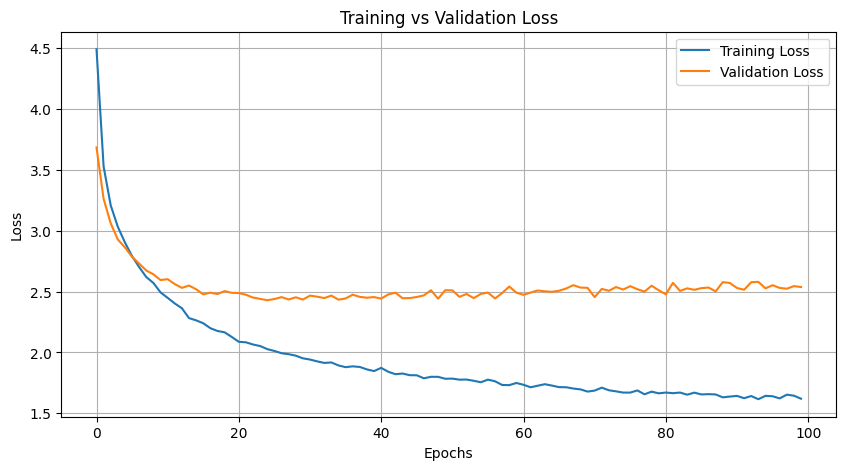

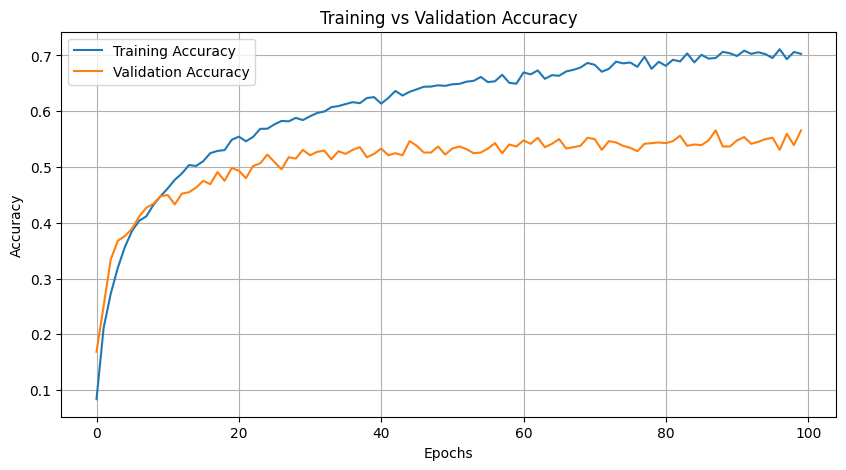

In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 加载模型
model = load_model('/content/ccn_model.h5')  # 替换为你的 .h5 文件路径


# Assuming `history` is the result of model.fit()

# Plot training and validation loss
def visualize_res(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.show()

  # Plot training and validation accuracy
  if 'accuracy' in history.history:  # Check if accuracy metrics exist
      plt.figure(figsize=(10, 5))
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training vs Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid()
      plt.show()
  else:
      print("Accuracy metrics were not recorded during training.")
visualize_res(history)

## show the report

In [9]:
import numpy as np
from sklearn.metrics import classification_report

def show_pose_acc(x_test,y_test,label_encoder):
  y_true = y_test
  y_pred = np.argmax(model.predict(x_test), axis=1)
  report = classification_report(y_true, y_pred, output_dict=True)




  print("each psoe acc：")
  for label, metrics in report.items():
      if label.isdigit():
          print(f"pose {label_encoder.classes_[int(label)]}: {metrics['precision']:.2f}")
          # print(f" {label}: {metrics['precision']:.2f}")

  print("\ntotal report：")
  print(classification_report(y_true, y_pred))
show_pose_acc(X_test,y_test_encoded,label_encoder)

30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step
each psoe acc：
pose adho mukha svanasana: 0.62
pose adho mukha vriksasana: 0.42
pose agnistambhasana: 0.00
pose ananda balasana: 0.60
pose anantasana: 0.80
pose anjaneyasana: 0.71
pose ardha bhekasana: 0.50
pose ardha chandrasana: 0.56
pose ardha matsyendrasana: 0.57
pose ardha pincha mayurasana: 0.45
pose ardha uttanasana: 0.46
pose ashtanga namaskara: 0.75
pose astavakrasana: 0.83
pose baddha konasana: 0.60
pose bakasana: 0.67
pose balasana: 0.64
pose bhairavasana: 0.67
pose bharadvajasana i: 0.25
pose bhekasana: 0.67
pose bhujangasana: 0.25
pose bhujapidasana: 0.50
pose bitilasana: 0.56
pose camatkarasana: 0.57
pose chakravakasana: 0.25
pose chaturanga dandasana: 0.50
pose dandasana: 1.00
pose dhanurasana: 0.83
pose durvasasana: 0.40
pose dwi pada viparita dandasana: 0.40
pose eka pada koundinyanasana i: 0.00
pose eka pada koundinyanasana ii: 0.17
pose eka pada rajakapotasana: 0.50
pose eka pada rajakapotasana ii: 0.60
pose ganda bherundasan

Duession:

 **From the results, we can infer that the model exhibits some degree of overfitting. Despite implementing various adjustments to prevent overfitting, such as dropout and data augmentation, it is evident that this model is either not well-suited for this dataset or lacks sufficient performance capability.**

# keypoints + mlp

## data pre-processing

In [1]:
def calculate_angle(pointA, pointB, pointC):
    """
    Calculate the angle formed by three points A, B, and C, where B is the vertex.
    """
    # Vectors AB and BC
    AB = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)

    # Dot product and vector norms (magnitudes)
    dot_product = np.dot(AB, BC)
    norm_AB = np.linalg.norm(AB)
    norm_BC = np.linalg.norm(BC)

    # Calculate the angle in radians and convert it to degrees
    angle_radian = math.acos(dot_product / (norm_AB * norm_BC + 1e-6))  # Add a small value to prevent division by zero
    angle_degree = math.degrees(angle_radian)

    # Return the angle rounded to two decimal places
    return round(angle_degree, 2)


Below are the key points and their corresponding body parts: (using mediapipe from Google)

0 - nose
1 - left eye (inner)
2 - left eye
3 - left eye (outer)
4 - right eye (inner)
5 - right eye
6 - right eye (outer)
7 - left ear
8 - right ear
9 - mouth (left)
10 - mouth (right)
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
17 - left pinky
18 - right pinky
19 - left index
20 - right index
21 - left thumb
22 - right thumb
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
29 - left heel
30 - right heel
31 - left foot index
32 - right foot index

Based on the spatial relationships between lines, when three lines intersect at a single point, knowing the angles between any two of the lines uniquely determines the third angle. This allows us to define the spatial positions of various body parts. The selected angles in the code are sufficient to determine the spatial postures of the upper arms, forearms, thighs, and calves on both sides of the body. These angles are chosen based on prior knowledge.

In [10]:
def get_angle(landmarks):
    # landmarks = results.pose_landmarks.landmark

    # Function to extract the coordinates of a given landmark
    get_coords = lambda point: (landmarks[point].x, landmarks[point].y)

    # Extract relevant key point coordinates
    points = {
        "12": get_coords(mp_pose.PoseLandmark.RIGHT_SHOULDER),  # Right shoulder
        "14": get_coords(mp_pose.PoseLandmark.RIGHT_ELBOW),     # Right elbow
        "24": get_coords(mp_pose.PoseLandmark.RIGHT_HIP),       # Right hip
        "26": get_coords(mp_pose.PoseLandmark.RIGHT_KNEE),      # Right knee
        "11": get_coords(mp_pose.PoseLandmark.LEFT_SHOULDER),   # Left shoulder
        "16": get_coords(mp_pose.PoseLandmark.RIGHT_WRIST),     # Right wrist
        "23": get_coords(mp_pose.PoseLandmark.LEFT_HIP),        # Left hip
        "13": get_coords(mp_pose.PoseLandmark.LEFT_ELBOW),      # Left elbow
        "15": get_coords(mp_pose.PoseLandmark.LEFT_WRIST),      # Left wrist
        "25": get_coords(mp_pose.PoseLandmark.LEFT_KNEE),       # Left knee
        "27": get_coords(mp_pose.PoseLandmark.LEFT_ANKLE),      # Left ankle
        "28": get_coords(mp_pose.PoseLandmark.RIGHT_ANKLE),     # Right ankle
    }

    # Calculate specific angles between the key points
    angles = {
        "16-14-12": calculate_angle(points["16"], points["14"], points["12"]),  # Right wrist, right elbow, right shoulder
        "14-12-11": calculate_angle(points["14"], points["12"], points["11"]),  # Right elbow, right shoulder, left shoulder
        "14-12-24": calculate_angle(points["14"], points["12"], points["24"]),  # Right elbow, right shoulder, right hip
        "12-24-26": calculate_angle(points["26"], points["24"], points["12"]),  # Right shoulder, right hip, right knee
        "26-24-23": calculate_angle(points["26"], points["24"], points["23"]),  # Right knee, right hip, left hip
        "24-26-28": calculate_angle(points["24"], points["26"], points["28"]),  # Right hip, right knee, right ankle

        "15-13-11": calculate_angle(points["15"], points["13"], points["11"]),  # Left wrist, left elbow, left shoulder
        "13-11-12": calculate_angle(points["13"], points["11"], points["12"]),  # Left elbow, left shoulder, right shoulder
        "13-11-23": calculate_angle(points["13"], points["11"], points["23"]),  # Left elbow, left shoulder, left hip
        "11-23-25": calculate_angle(points["11"], points["23"], points["25"]),  # Left shoulder, left hip, left knee
        "24-23-25": calculate_angle(points["24"], points["23"], points["25"]),  # Right hip, left hip, left knee
        "23-25-27": calculate_angle(points["23"], points["25"], points["27"]),  # Left hip, left knee, left ankle
    }

    return angles

# Angle list for reference
angle_list = [
    '16-14-12', '14-12-11', '14-12-24', '12-24-26', '26-24-23', '24-26-28',
    '15-13-11', '13-11-12', '13-11-23', '11-23-25', '24-23-25', '23-25-27'
]


Extract the key points from the images in the training set, test set, and validation set, and save them to corresponding CSV files. Since the key point coordinates provided by MediaPipe include four values, we only retain the x and y coordinates, discarding z and confidence (p). Additionally, the x and y coordinates are separated into two distinct features.

In [13]:
import os
import cv2
import mediapipe as mp
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose module
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# Input folder path containing images
input_folder = "/content/test/"  # Replace with your image folder path
output_csv = "test.csv"  # Name of the output CSV file

def write_keypoints_incsv(folder_path, output_csv):
    """
    Function to extract pose keypoints from images in a folder and write them to a CSV file.

    Parameters:
    - folder_path: Path to the folder containing subfolders of images.
    - output_csv: Name of the output CSV file to save the keypoints.
    """
    # Open CSV file for writing
    with open(output_csv, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)

        # Write the header row (Action name, keypoints for 33 landmarks, angles)
        header = ["Action Name"] + [f"{i}_{coord}" for i in range(1, 34) for coord in ['x', 'y']] + angle_list
        writer.writerow(header)

    # Loop through all subfolders in the main folder
    for p in os.listdir(folder_path):
        input_subfolder = os.path.join(folder_path, p)
        if not os.path.isdir(input_subfolder):  # Skip non-folder items
            continue

        # Get all image files in the subfolder
        supported_formats = [".jpg", ".jpeg", ".png"]  # Supported image formats
        image_files = [f for f in os.listdir(input_subfolder) if os.path.splitext(f)[1].lower() in supported_formats]

        # Append data from each action's images to the CSV file
        with open(output_csv, mode="a", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)

            for image_file in image_files:
                image_path = os.path.join(input_subfolder, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Unable to load image: {image_path}")
                    continue

                # Convert the image to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Detect pose keypoints
                results = pose.process(image_rgb)

                # Initialize row data
                row = []
                if results.pose_landmarks:
                    row.append(p)  # First column is the action name

                    # Add (x, y) coordinates of 33 landmarks to the row
                    for landmark in results.pose_landmarks.landmark:
                        row.append(f"{landmark.x:.6f}")
                        row.append(f"{landmark.y:.6f}")

                    # Calculate angles for the keypoints and add them to the row
                    angles = get_angle(results.pose_landmarks.landmark)
                    row = row + list(angles.values())
                    writer.writerow(row)

                else:
                    # If no keypoints are detected, log the image path
                    pass

# Call the function for test, train, and validation folders
write_keypoints_incsv(input_folder, output_csv)
write_keypoints_incsv('/content/train', 'train.csv')
write_keypoints_incsv('/content/valid', 'valid.csv')


### RFE feature selects

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

# Read the dataset
file_path = '/content/train.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = data.iloc[:, 1:]  # All columns except the first one are features
y = data.iloc[:, 0]   # The first column is the target variable

# Encode the target variable (if it is categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize the Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=78, step=1)  # Select 78 features
rfe.fit(X, y_encoded)

# Calculate feature importances using the Random Forest model
importance_values = model.fit(X, y_encoded).feature_importances_

# Create a DataFrame to store feature importances and rankings
feature_importances = pd.DataFrame({
    'Feature': X.columns,  # Feature names
    'Ranking': rfe.ranking_,  # RFE feature rankings
    'Importance': importance_values  # Feature importance values from Random Forest
}).sort_values(by='Importance', ascending=False)  # Sort by importance in descending order

# Print the feature importances
print(feature_importances)

# Save the feature importances to a CSV file (if needed)
feature_importances.to_csv('feature_importances.csv', index=False)

# name is just considering importance
name = list(pd.read_csv('/content/feature_importances.csv')[-30:]['Feature'])


     Feature  Ranking  Importance
47      24_y        1    0.024665
75  11-23-25        1    0.024498
69  12-24-26        1    0.024300
49      25_y        1    0.024109
71  24-26-28        1    0.022009
..       ...      ...         ...
12       7_x        1    0.007426
10       6_x        1    0.007389
8        5_x        1    0.007318
2        2_x        1    0.007303
4        3_x        1    0.006930

[78 rows x 3 columns]


In [16]:
import pandas as pd

def save_kp_importance(feature_importances_file, keypoint_importance_name):
    """
    Calculate and save the cumulative importance of each keypoint
    based on feature importances from a CSV file.

    Parameters:
    - feature_importances_file: Path to the CSV file containing feature importances.
    - keypoint_importance_name: Name for the output CSV file to save keypoint importances.
    """

    # Read the feature importances data
    # Example: feature_importances_file = '/content/feature_importances.csv'
    feature_importances = pd.read_csv(feature_importances_file)

    # Dictionary to store cumulative importance for each keypoint
    keypoints_importance = {}

    # Iterate through each feature and its importance
    for index, row in feature_importances.iterrows():
        feature = row['Feature']  # Extract the feature name
        importance = row['Importance']  # Extract the feature's importance value

        # Parse the keypoint ID (e.g., "1_x" and "1_y" belong to Keypoint 1)
        if '_' in feature:
            keypoint = feature.split('_')[0]  # Extract the keypoint ID
            if keypoint not in keypoints_importance:
                keypoints_importance[keypoint] = 0
            keypoints_importance[keypoint] += importance  # Add importance to the keypoint's total

    # Convert the cumulative keypoint importance dictionary to a DataFrame
    keypoints_importance_df = pd.DataFrame(
        list(keypoints_importance.items()),
        columns=['Keypoint', 'Importance']
    )
    # Sort the DataFrame by importance in descending order
    keypoints_importance_df = keypoints_importance_df.sort_values(by='Importance', ascending=False)

    # Save the keypoint importance as a CSV file
    keypoints_importance_df.to_csv(f'{keypoint_importance_name}.csv', index=False)


save_kp_importance('/content/feature_importances.csv', 'keypoint_importance_RFE')


In [24]:
kp_path = '/content/keypoint_importances.csv'
kp = pd.read_csv('/content/keypoint_importance_RFE.csv').iloc[:46]['Keypoint']
kp_name = [f"{i}_{coord}" for i in kp for coord in ['x', 'y']]
kp_name += list(pd.read_csv('/content/train.csv').columns[-12:])
kp_name #considering x+y importances


### Correlation Coefficient Method
Since testing has shown that RFE performs better than the correlation coefficient method, the test section for the correlation coefficient method will not be displayed.

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

def k_test(path):
    """
    Apply the correlation coefficient method to evaluate the importance of features.

    Parameters:
    - path: Path to the CSV file containing the dataset.

    Returns:
    - A DataFrame with features and their correlation scores, sorted by absolute value of correlation.
    """
    # Load the dataset from the specified path
    df = pd.read_csv(path)

    # Separate the feature matrix (X) and the target variable (y)
    X = df.iloc[:, 1:]  # All columns except the first one are features
    y = df['Action Name']  # The first column represents the target variable

    # List to store correlation scores
    correlation_scores = []

    # Encode the target variable (if it is categorical)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Compute Pearson correlation coefficient for each feature
    for column in X.columns:
        corr, _ = pearsonr(X[column], y)  # Calculate Pearson correlation coefficient
        correlation_scores.append((column, corr))  # Store the feature and its correlation score

    # Convert the results to a DataFrame
    scores_df = pd.DataFrame(correlation_scores, columns=['Feature', 'Correlation'])

    # Display the correlation scores
    print("Correlation scores (using Pearson correlation):")
    print(scores_df)

    # Sort the features by the absolute value of their correlation scores in descending order
    sorted_scores = scores_df.sort_values(by='Correlation', key=np.abs, ascending=False)
    print("\nFeatures sorted by absolute value of correlation:")
    print(sorted_scores)

    return sorted_scores

# Example usage
k_test('/content/train.csv').to_csv('feature_importances_c.csv', index=False)


Correlation scores (using Pearson correlation):
     Feature  Correlation
0        1_x    -0.013914
1        1_y    -0.117290
2        2_x    -0.017546
3        2_y    -0.097191
4        3_x    -0.017797
..       ...          ...
73  13-11-12     0.080879
74  13-11-23     0.044769
75  11-23-25     0.148682
76  24-23-25     0.039434
77  23-25-27     0.066446

[78 rows x 2 columns]

Features sorted by absolute value of correlation:
     Feature  Correlation
75  11-23-25     0.148682
43      22_y    -0.145392
39      20_y    -0.143017
31      16_y    -0.142706
35      18_y    -0.139614
..       ...          ...
18      10_x    -0.011429
42      22_x    -0.011191
38      20_x    -0.010528
53      27_y    -0.007363
22      12_x    -0.006975

[78 rows x 2 columns]


### encode

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Paths to training, testing, and validation datasets (coordinate-separated version)
train_path = '/content/train.csv'  # Training dataset path
test_path = '/content/test.csv'    # Testing dataset path
valid_path = '/content/valid.csv'  # Validation dataset path

# Initialize StandardScaler for feature normalization
scaler = StandardScaler()

# Initialize LabelEncoder for encoding class labels
label_encoder = LabelEncoder()

# Read the labels from the training and testing datasets
train_labels = pd.read_csv(train_path).iloc[:, 0]  # Labels from the training dataset
test_labels = pd.read_csv(test_path).iloc[:, 0]    # Labels from the testing dataset

# Fit the LabelEncoder using training labels
label_encoder.fit(train_labels)


X_train = scaler.fit_transform(pd.read_csv(train_path)[kp_name])  # Normalize training features
y_train = label_encoder.fit_transform(pd.read_csv(train_path).iloc[:, 0])  # Encode training labels

X_test = scaler.fit_transform(pd.read_csv(test_path)[kp_name])  # Normalize testing features
y_test = label_encoder.fit_transform(pd.read_csv(test_path).iloc[:, 0])  # Encode testing labels

X_val = scaler.fit_transform(pd.read_csv(valid_path)[kp_name])  # Normalize validation features
y_val = label_encoder.fit_transform(pd.read_csv(valid_path).iloc[:, 0])  # Encode validation labels


only consider the importances of each features

In [35]:
X_train_d = scaler.fit_transform(pd.read_csv(train_path)[name])
y_train_d = label_encoder.fit_transform(pd.read_csv(train_path).iloc[:, 0])
X_test_d = scaler.fit_transform(pd.read_csv(test_path)[name])
y_test_d = label_encoder.fit_transform(pd.read_csv(test_path).iloc[:, 0])
X_val_d = scaler.fit_transform(pd.read_csv(valid_path)[name])
y_val_d = label_encoder.fit_transform(pd.read_csv(valid_path).iloc[:, 0])



## mlp model set up

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Define the MLP model
model = Sequential([
    # First dense layer with L2 regularization to prevent overfitting
    Dense(128, input_shape=(len(kp_name),), activation='relu',
          kernel_regularizer=l2(0.001)),  # Reduced L2 regularization strength
    Dropout(0.1),  # Dropout to reduce overfitting

    # Second dense layer
    Dense(256, activation='relu',
          kernel_regularizer=l2(0.001)),

    # Third dense layer
    Dense(128, activation='relu',
          kernel_regularizer=l2(0.001)),
    Dropout(0.1),  # Additional dropout layer

    # Output layer with softmax activation for multi-class classification
    Dense(107, activation='softmax',
          kernel_regularizer=l2(0.001))  # 107 classes in the dataset
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rate
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric
)

# Display the model architecture
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Validation data for monitoring performance
    epochs=100,  # Number of epochs
    batch_size=16  # Batch size for training
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 107)                 │          13,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,835 (350.92 KB)

 Trainable params: 89,835 (350.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1011 - loss: 4.6418 - val_accuracy: 0.4524 - val_loss: 2.6788
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4400 - loss: 2.6039 - val_accuracy: 0.5645 - val_loss: 2.1799
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 2.1504 - val_accuracy: 0.5983 - val_loss: 2.0204
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5910 - loss: 1.9865 - val_accuracy: 0.6333 - val_loss: 1.8996
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 1.8146 - val_accuracy: 0.6598 - val_loss: 1.8256
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 1.7378 - val_accuracy: 0.6309 - val_loss: 1.8603
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 1.6472 - val_accuracy: 0.6369 - val_loss: 1.8183
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7098 - loss: 1.5629 - val_acc

### visualize trainging process

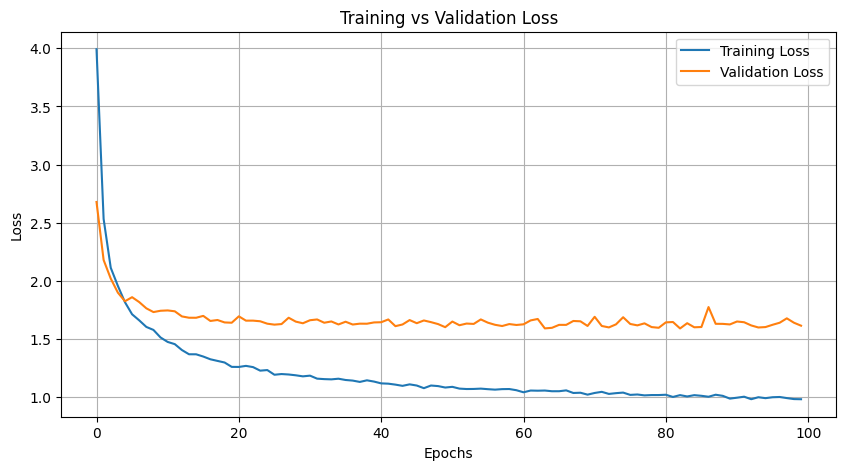

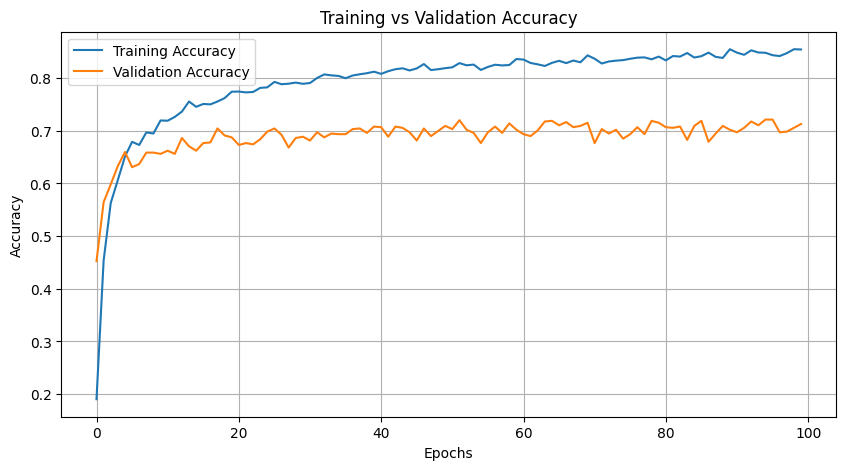

In [30]:
visualize_res(history)

### show the report

In [31]:
show_pose_acc(X_test,y_test,label_encoder)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
each psoe acc：
pose adho mukha svanasana: 0.73
pose adho mukha vriksasana: 0.80
pose agnistambhasana: 1.00
pose ananda balasana: 0.75
pose anantasana: 0.86
pose anjaneyasana: 0.64
pose ardha bhekasana: 1.00
pose ardha chandrasana: 0.75
pose ardha matsyendrasana: 0.85
pose ardha pincha mayurasana: 1.00
pose ardha uttanasana: 0.47
pose ashtanga namaskara: 1.00
pose astavakrasana: 0.71
pose baddha konasana: 0.54
pose bakasana: 0.92
pose balasana: 0.73
pose bhairavasana: 0.71
pose bharadvajasana i: 0.67
pose bhekasana: 0.50
pose bhujangasana: 0.69
pose bhujapidasana: 0.88
pose bitilasana: 0.71
pose camatkarasana: 0.90
pose chakravakasana: 0.36
pose chaturanga dandasana: 0.75
pose dandasana: 1.00
pose dhanurasana: 0.83
pose durvasasana: 0.40
pose dwi pada viparita dandasana: 0.86
pose eka pada koundinyanasana i: 0.36
pose eka pada koundinyanasana ii: 0.20
pose eka pada rajakapotasana: 0.30
pose eka pada rajakapotasana ii: 1.00
pose ganda bherundasana:

**all above is consider x+y's importance**

### only consider importances results

In [36]:
# Define the MLP model
model = Sequential([
    # First dense layer with L2 regularization to prevent overfitting
    Dense(128, input_shape=(len(name),), activation='relu',
          kernel_regularizer=l2(0.001)),  # Reduced L2 regularization strength
    Dropout(0.1),  # Dropout to reduce overfitting

    # Second dense layer
    Dense(256, activation='relu',
          kernel_regularizer=l2(0.001)),

    # Third dense layer
    Dense(128, activation='relu',
          kernel_regularizer=l2(0.001)),
    Dropout(0.1),  # Additional dropout layer

    # Output layer with softmax activation for multi-class classification
    Dense(107, activation='softmax',
          kernel_regularizer=l2(0.001))  # 107 classes in the dataset
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rate
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric
)
# Train the model
history = model.fit(
    X_train_d, y_train_d,
    validation_data=(X_val_d, y_val_d),  # Validation data for monitoring performance
    epochs=100,  # Number of epochs
    batch_size=16  # Batch size for training
)
show_pose_acc(X_test_d,y_test_d,label_encoder)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0538 - loss: 4.8483 - val_accuracy: 0.1689 - val_loss: 3.6843
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1964 - loss: 3.6220 - val_accuracy: 0.2509 - val_loss: 3.2612
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2539 - loss: 3.2242 - val_accuracy: 0.3341 - val_loss: 3.0600
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3224 - loss: 3.0156 - val_accuracy: 0.3679 - val_loss: 2.9276
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3534 - loss: 2.9163 - val_accuracy: 0.3764 - val_loss: 2.8622
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3890 - loss: 2.7669 - val_accuracy: 0.3896 - val_loss: 2.7852
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4084 - loss: 2.6863 - val_accuracy: 0.4113 - val_loss: 2.7292
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4069 - loss: 2.6221 - val_accuracy: 0.427

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Discussion

From the results we can see the up one is much better than latter down one(only consider the importances), I believe that key points should be considered as a whole and cannot be viewed separately as individual x and y coordinates. This approach does not align with logical reasoning.